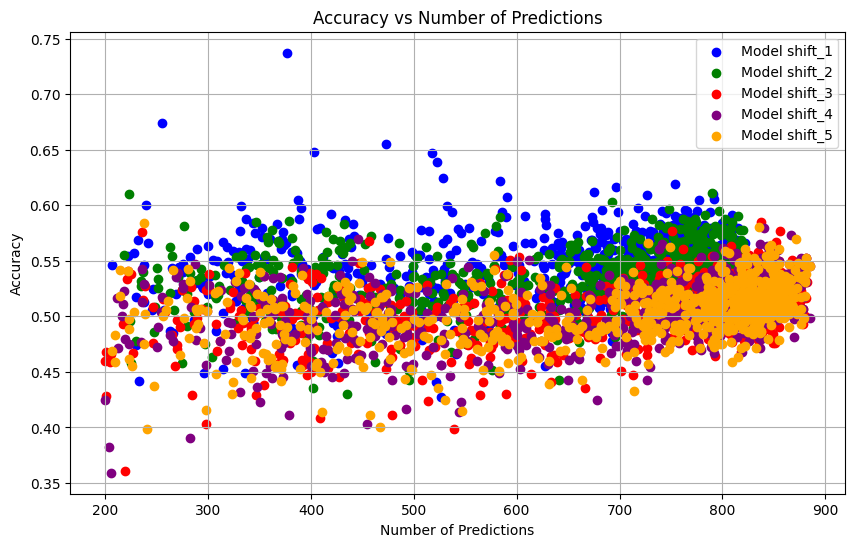


Validation Summary:
Total files processed: 846
  - shift_1 (Files with >= 3 predictions): 760 Average Accuracy: 0.55
  - shift_2 (Files with >= 3 predictions): 758 Average Accuracy: 0.54
  - shift_3 (Files with >= 3 predictions): 766 Average Accuracy: 0.51
  - shift_4 (Files with >= 3 predictions): 765 Average Accuracy: 0.51
  - shift_5 (Files with >= 3 predictions): 759 Average Accuracy: 0.51
Files with insufficient predictions:


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def validate_model_with_min_predictions(directory_path, min_predictions=200, model_shifts=[1, 2, 3, 4, 5]):
    summary_results = {
        "total_files": 0,
        "total_files_with_min_predictions": 0,
        "model_accuracies": {f"shift_{i}": [] for i in model_shifts},
        "combined_accuracy": [],
        "files_with_few_predictions": [],
        "prediction_counts": {f"shift_{i}": [] for i in model_shifts}
    }

    files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

    for file_name in files:
        file_path = os.path.join(directory_path, file_name)
        data = pd.read_csv(file_path)
        data['Date'] = pd.to_datetime(data['Date'])
        data['percentMove'] = data['Close'].pct_change()
        data['next_day_price_rise'] = data['percentMove'].shift(-1) > 0

        summary_results["total_files"] += 1

        for i, shift in enumerate(model_shifts, start=1):
            up_prob_col = f'UpProb_Shift_{shift}'
            down_prob_col = f'DownProb_Shift_{shift}'
            prediction_col = f'Prediction_Shift_{shift}'

            data[prediction_col] = data[up_prob_col] > 0.45  # Threshold can be adjusted
            selected_data = data[data[prediction_col]].copy()
            TP = selected_data[selected_data['next_day_price_rise']].shape[0]
            total_predictions_shift = selected_data.shape[0]
            if total_predictions_shift >= min_predictions:
                accuracy_shift = TP / total_predictions_shift if total_predictions_shift else 0
                summary_results['model_accuracies'][f"shift_{shift}"].append(accuracy_shift)
                summary_results['prediction_counts'][f"shift_{shift}"].append(total_predictions_shift)

    return summary_results


def plot_accuracy_vs_predictions(summary):
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    for i, model in enumerate(summary['model_accuracies'].keys(), start=1):
        x_values = summary['prediction_counts'][model]
        y_values = summary['model_accuracies'][model]
        if x_values and y_values:
            plt.scatter(x_values, y_values, color=colors[i-1], label=f"Model {model}")
    plt.title('Accuracy vs Number of Predictions')
    plt.xlabel('Number of Predictions')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()


def print_summary(summary):
    print("\nValidation Summary:")
    print(f"Total files processed: {summary['total_files']}")
    for model, accuracies in summary['model_accuracies'].items():
        if accuracies:
            print(f"  - {model} (Files with >= 3 predictions): {len(accuracies)} Average Accuracy: {np.mean(accuracies):.2f}")
    print("Files with insufficient predictions:")
    for file in summary['files_with_few_predictions']:
        print(f"  - {file}")


# Example usage
directory_path = 'Data/RFpredictions'
summary_results = validate_model_with_min_predictions(directory_path)
plot_accuracy_vs_predictions(summary_results)
print_summary(summary_results)
